<a href="https://colab.research.google.com/github/Jaelibj/JaeliJaussi/blob/main/notebooks/starter_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The core task we're interested in is identifying those customers most likely to subscribe to a term deposit.

A term deposit is a fixed-term investment that includes the deposit of money into an account at a financial institution. In this case, our financial institution.

I don't know a lot about data science, but I've been trying to get up to speed. Do you think a supervised or unsupervised approach would work best for this situation?

Supervised with a tree model. We want to predict the y column (whether someone will make a term deposit) based on the other categorical data.

Miguel, that is a great question.

While we are asking detailed questions, the dataset has approximately 37,000 records. How much of that data will you use to train your model?

Based on your initial analysis of the data, your team feels:

A simple 80/20 split will provide us with enough to accurately train and test our model.
A 50/50 split so that we have the same amount of training data as testing.
We will pull out 1,000 records for our test dataset and use the other 36,000 for training. This gives our model more to train on and will produce better results.
We will use all 37,000 for training and use cross-validation to evaluate the model.

80/20 split for training and testing

Aside from the core marketing question Miguel mentioned, I'm wondering if there are other insights we could gain from our data.

I can look at the data and tell that some days of the week or some months produce better results than others.

I'm wondering if it's possible for us to see if those results are true for all customers, or if some types of customers respond better on certain days than others?

Since we're operating in the European Union, we're subject to GDPR compliance requirements.

What do you think we might need to do for this project in order to be compliant with GDPR regulations?

Beatriz, Senior Data Scientist asks:
Since we're operating in the European Union, we're subject to GDPR compliance requirements.

What do you think we might need to do for this project in order to be compliant with GDPR regulations?

Based on your initial analysis of the data, your team feels:

This is historic data, so we should be just fine.
This is anonymous data, so we should be just fine.
The GDPR doesn't apply in this situation, since we're just building a model, not selling data.
In order to use this data under GDPR, we'll need to get consent from the customers in the dataset.

GDPR does not apply because our data is anonymous.

Who is more likely to make a term deposit?

Other questions to answer

- Which people should be called on which day/month? Robert and Shaun
- Does frequent contact poorly affect marketing campaigns? Dylan
- Make different models for different economic contexts. Jaeli and Peter

In [15]:
import pandas as pd

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

campaign.head()
campaign.info()
campaign.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37069 non-null  int64  
 1   job             37069 non-null  object 
 2   marital         37069 non-null  object 
 3   education       37069 non-null  object 
 4   default         37069 non-null  object 
 5   housing         37069 non-null  object 
 6   loan            37069 non-null  object 
 7   contact         37069 non-null  object 
 8   month           37069 non-null  object 
 9   day_of_week     37069 non-null  object 
 10  campaign        37069 non-null  int64  
 11  pdays           37069 non-null  int64  
 12  previous        37069 non-null  int64  
 13  poutcome        37069 non-null  object 
 14  emp.var.rate    37069 non-null  float64
 15  cons.price.idx  37069 non-null  float64
 16  cons.conf.idx   37069 non-null  float64
 17  euribor3m       37069 non-null 

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000,37069.000000
mean,40.025493,2.564407,962.221803,0.173730,0.081526,93.576551,-40.494829,3.621945,5167.010650
std,10.435288,2.764084,187.531477,0.496159,1.572287,0.579339,4.628895,1.734496,72.294476
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


<Axes: xlabel='day_of_week', ylabel='y_yes'>

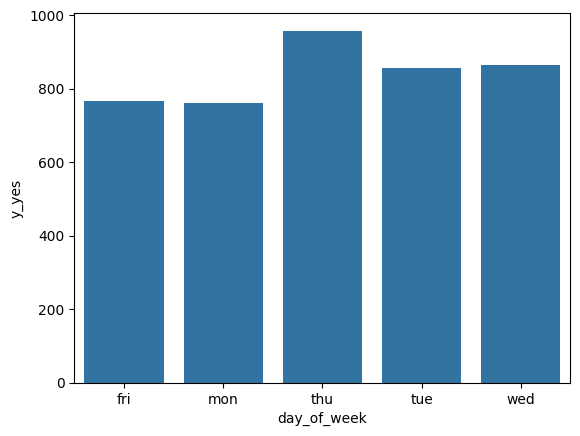

In [16]:
import seaborn as sns

df_day= (
    campaign
      .groupby('day_of_week')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x== "yes").sum())
      )
      .reset_index()
)
sns.barplot(
    data=df_day,
    x='day_of_week',
    y='y_yes'
)

<Axes: xlabel='day_of_week', ylabel='y_yes'>

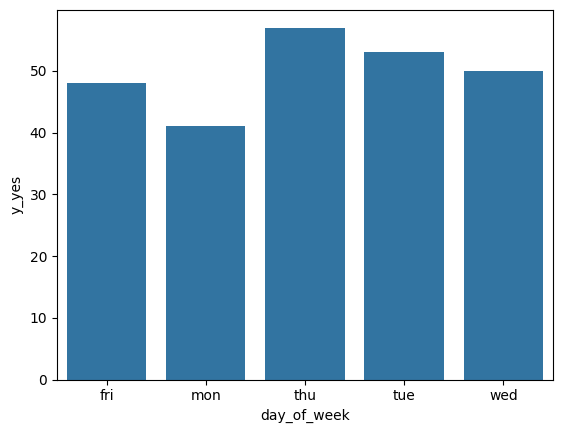

In [17]:
df_day= (
    campaign[campaign['job']== 'student']
      .groupby('day_of_week')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x== "yes").sum())
      )
      .reset_index()
)
sns.barplot(
    data=df_day,
    x='day_of_week',
    y='y_yes'
)

Make different models for different economic contexts.

In [18]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

df = campaign.copy()

# Convert target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Encode categorical variables
X = pd.get_dummies(df.drop(columns='y'), drop_first=True)
y = df['y']

df['econ_context'] = pd.qcut(
    df['euribor3m'],
    q=5,
    labels=False
)

models = {}

for context in range(5):
    print(f"\nEconomic Context {context}")
    print("-" * 40)

    # Filter data for context
    context_idx = df['econ_context'] == context
    X_context = X.loc[context_idx]
    y_context = y.loc[context_idx]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_context,
        y_context,
        test_size=0.2,
        random_state=42,
        stratify=y_context
    )

    # Decision Tree model
    model = DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=50,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Store model
    models[context] = model



Economic Context 0
----------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      1089
           1       0.69      0.36      0.47       465

    accuracy                           0.76      1554
   macro avg       0.73      0.65      0.66      1554
weighted avg       0.75      0.76      0.73      1554


Economic Context 1
----------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1349
           1       0.43      0.09      0.15       166

    accuracy                           0.89      1515
   macro avg       0.66      0.54      0.54      1515
weighted avg       0.85      0.89      0.85      1515


Economic Context 2
----------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1472
           1       0.00      0.00      0.00        54


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

campaign = pd.read_csv(
    'https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv'
)

Model 1: Employment Variation Rate (emp.var.rate)

Question: How does subscription success vary by employment conditions?

/tmp/ipython-input-3855154566.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('emp_bin')


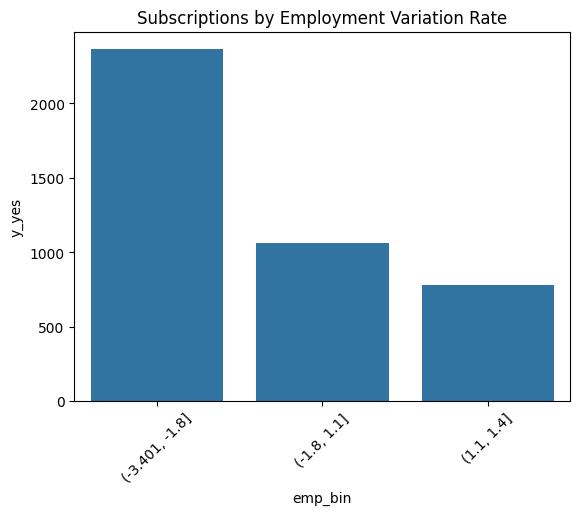

In [20]:
campaign['emp_bin'] = pd.qcut(
    campaign['emp.var.rate'],
    q=4,
    duplicates='drop'
)

df_emp = (
    campaign
      .groupby('emp_bin')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x == 'yes').sum())
      )
      .reset_index()
)

sns.barplot(
    data=df_emp,
    x='emp_bin',
    y='y_yes'
)
plt.xticks(rotation=45)
plt.title('Subscriptions by Employment Variation Rate')
plt.show()


Model 2: Consumer Price Index (cons.price.idx)

Question: Do higher prices affect campaign success?

/tmp/ipython-input-3001552865.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('price_bin')


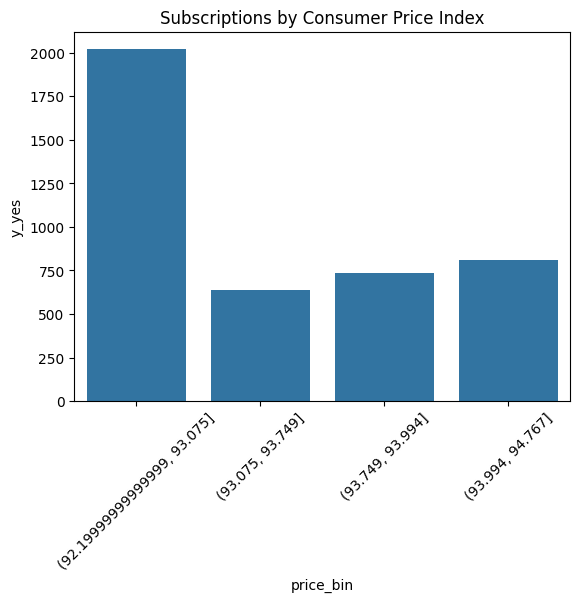

In [21]:
campaign['price_bin'] = pd.qcut(
    campaign['cons.price.idx'],
    q=4,
    duplicates='drop'
)

df_price = (
    campaign
      .groupby('price_bin')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x == 'yes').sum())
      )
      .reset_index()
)

sns.barplot(
    data=df_price,
    x='price_bin',
    y='y_yes'
)
plt.xticks(rotation=45)
plt.title('Subscriptions by Consumer Price Index')
plt.show()


Model 3: Consumer Confidence Index (cons.conf.idx)

Question: Does consumer confidence correlate with success?

/tmp/ipython-input-2892907372.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('conf_bin')


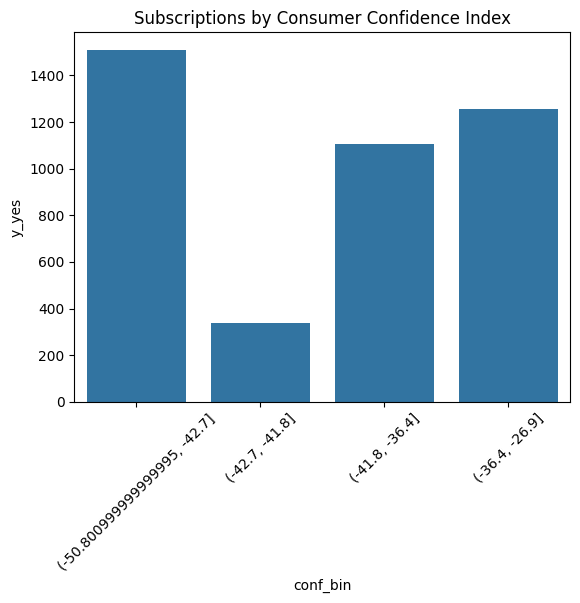

In [22]:
campaign['conf_bin'] = pd.qcut(
    campaign['cons.conf.idx'],
    q=4,
    duplicates='drop'
)

df_conf = (
    campaign
      .groupby('conf_bin')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x == 'yes').sum())
      )
      .reset_index()
)

sns.barplot(
    data=df_conf,
    x='conf_bin',
    y='y_yes'
)
plt.xticks(rotation=45)
plt.title('Subscriptions by Consumer Confidence Index')
plt.show()


Model 4: Euribor 3-Month Rate (euribor3m)

Question: How do interest rates impact subscriptions?

/tmp/ipython-input-4186568377.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('euribor_bin')


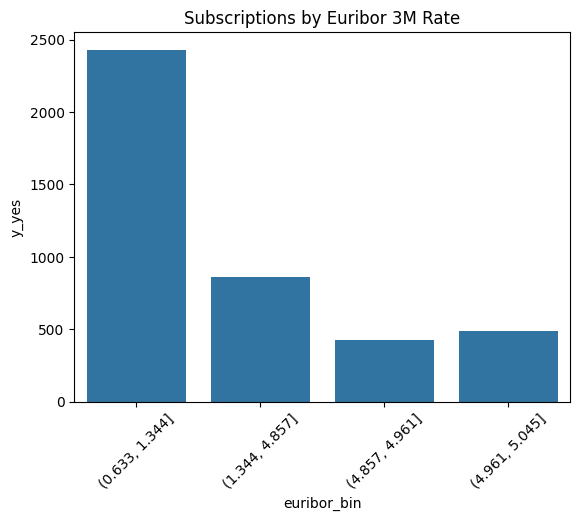

In [23]:
campaign['euribor_bin'] = pd.qcut(
    campaign['euribor3m'],
    q=4,
    duplicates='drop'
)

df_euribor = (
    campaign
      .groupby('euribor_bin')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x == 'yes').sum())
      )
      .reset_index()
)

sns.barplot(
    data=df_euribor,
    x='euribor_bin',
    y='y_yes'
)
plt.xticks(rotation=45)
plt.title('Subscriptions by Euribor 3M Rate')
plt.show()


Model 5: Number of Employed (nr.employed)

Question: Does overall employment level matter?

/tmp/ipython-input-3004665151.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('employed_bin')


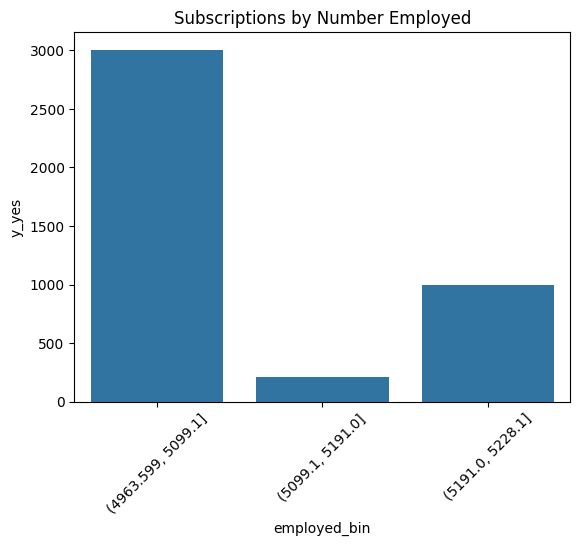

In [24]:
campaign['employed_bin'] = pd.qcut(
    campaign['nr.employed'],
    q=4,
    duplicates='drop'
)

df_employed = (
    campaign
      .groupby('employed_bin')
      .agg(
          total=('y', 'size'),
          y_yes=('y', lambda x: (x == 'yes').sum())
      )
      .reset_index()
)

sns.barplot(
    data=df_employed,
    x='employed_bin',
    y='y_yes'
)
plt.xticks(rotation=45)
plt.title('Subscriptions by Number Employed')
plt.show()


Employment Variation Rate → Line Plot (Trend)

Why: emp.var.rate is time-based and ordered. A line plot highlights trends.

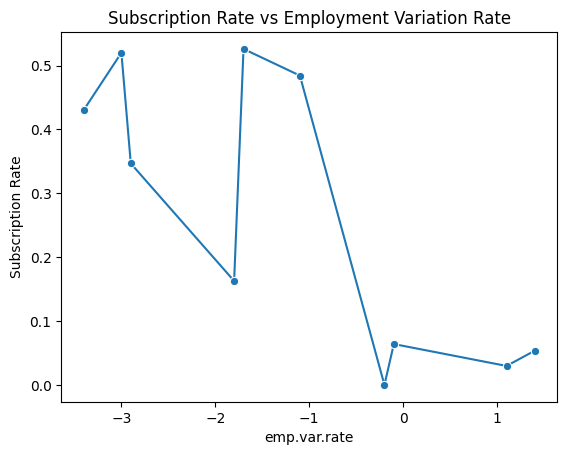

In [25]:
df_emp = (
    campaign
      .groupby('emp.var.rate')
      .agg(
          subscribe_rate=('y', lambda x: (x == 'yes').mean())
      )
      .reset_index()
      .sort_values('emp.var.rate')
)

sns.lineplot(
    data=df_emp,
    x='emp.var.rate',
    y='subscribe_rate',
    marker='o'
)
plt.title('Subscription Rate vs Employment Variation Rate')
plt.ylabel('Subscription Rate')
plt.show()


Consumer Price Index → Box Plot

Why: CPI varies continuously, and boxplots show spread + outliers well.

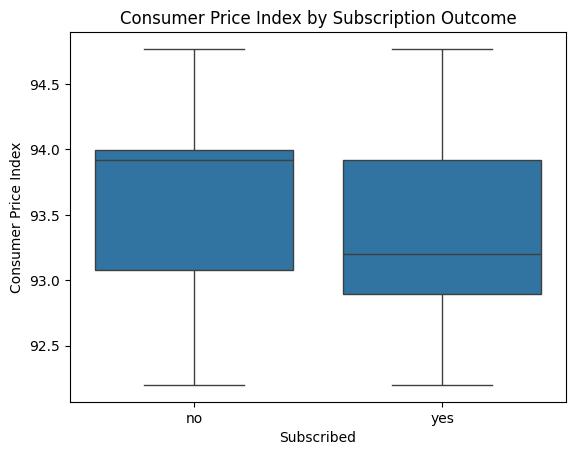

In [26]:
sns.boxplot(
    data=campaign,
    x='y',
    y='cons.price.idx'
)
plt.title('Consumer Price Index by Subscription Outcome')
plt.xlabel('Subscribed')
plt.ylabel('Consumer Price Index')
plt.show()


A violin plot shows how your data is distributed and key summary statistics at the same time.

Think of it as:

Histogram + boxplot = violin plot

1. Width = how common values are

This is the most important thing.

Wide sections → lots of observations there

Narrow sections → fewer observations

So if the violin is fat around −40 and skinny around −30, most data points are near −40.

Rule of thumb:

Wider = more common

2. Height = actual data values

The top to bottom of the violin shows:

Minimum to maximum values of the variable

The y-axis numbers are real data values

Example for cons.conf.idx:

Bottom: very low confidence

Top: higher confidence

3. The inside lines (quartiles & median)

Because you used:

inner='quartile'


You’ll see three horizontal lines inside each violin:

Line	Meaning
Middle line	Median (50th percentile)
Lower line	25th percentile
Upper line	75th percentile

This tells you:

Where the typical value is

How spread out the middle 50% is

Consumer Confidence Index → Violin Plot

Why: Confidence is sentiment-based; violins show distribution shape better than boxes.

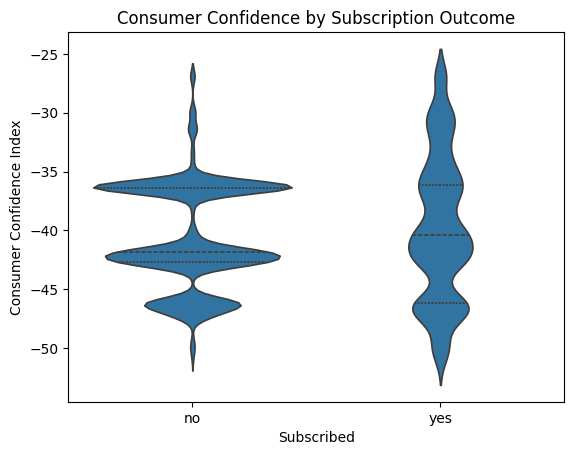

In [27]:
sns.violinplot(
    data=campaign,
    x='y',
    y='cons.conf.idx',
    inner='quartile'
)
plt.title('Consumer Confidence by Subscription Outcome')
plt.xlabel('Subscribed')
plt.ylabel('Consumer Confidence Index')
plt.show()


Euribor 3-Month Rate → Histogram with Hue

Why: Interest rates affect behavior gradually; overlapping distributions work well.

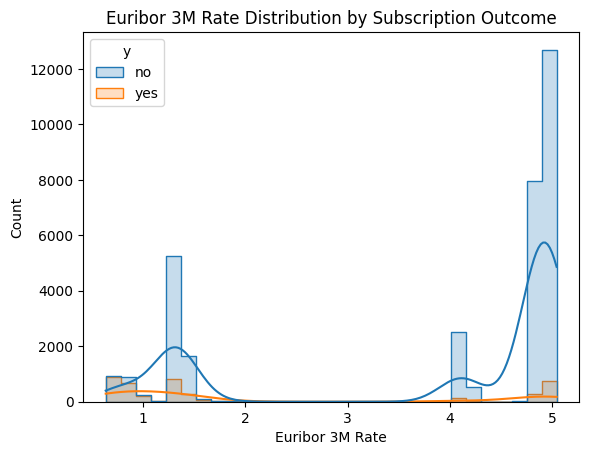

In [28]:
sns.histplot(
    data=campaign,
    x='euribor3m',
    hue='y',
    bins=30,
    kde=True,
    element='step'
)
plt.title('Euribor 3M Rate Distribution by Subscription Outcome')
plt.xlabel('Euribor 3M Rate')
plt.show()


Number Employed → Scatter + Regression Line

Why: nr.employed is large-scale and continuous; scatter + trend shows correlation.

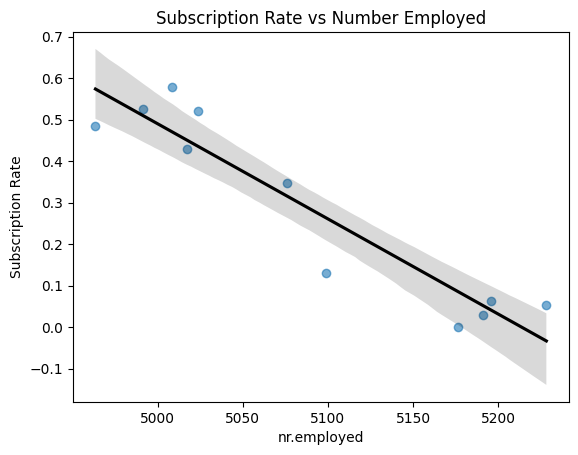

In [29]:
df_emp_level = (
    campaign
      .groupby('nr.employed')
      .agg(
          subscribe_rate=('y', lambda x: (x == 'yes').mean())
      )
      .reset_index()
)

sns.regplot(
    data=df_emp_level,
    x='nr.employed',
    y='subscribe_rate',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'black'}
)
plt.title('Subscription Rate vs Number Employed')
plt.ylabel('Subscription Rate')
plt.show()
